In [4]:
import cv2
import pandas as pd
import os 
import matplotlib.pyplot as plt
import numpy as np

In [5]:
dataset_path = "C:\\Users\\lenovo\\Desktop\\Projets\\IMAGE_processing\\chest_xray"

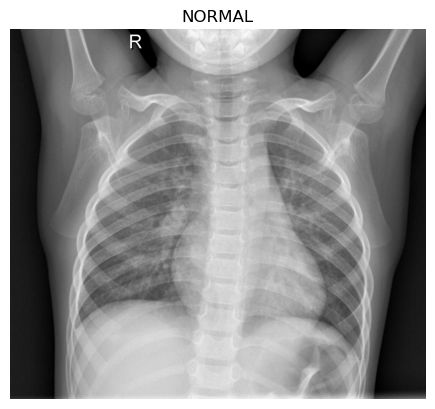

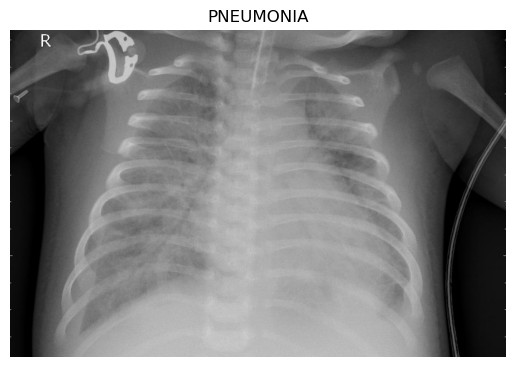

In [12]:
categories = ["NORMAL", "PNEUMONIA"]  # Les classes du dataset
n = 0
for category in categories:
    category_path = os.path.join(dataset_path, category)
    
    for img_name in os.listdir(category_path):
        # Construction du chemin complet de l'image
        img_path = os.path.join(category_path, img_name)
        
        # Lire l'image avec OpenCV
        img = cv2.imread(img_path)
        
        # Afficher l'image avec OpenCV (convertir de BGR à RGB pour l'affichage correct avec matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.title(category)
        plt.axis("off")
        plt.show()
        n+=1
        # Vous pouvez ajouter un `break` pour tester l'affichage avec une seule image
        break


In [7]:
categories = ["NORMAL", "PNEUMONIA"]  # Les classes du dataset
types = ["train", "test", "val"]
n = 0
img_size = 224
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
val_path = os.path.join(dataset_path, "val")

train_data = []
test_data = []
val_data = []
labels_train = []
labels_test = []
labels_val = []


for category in categories:
    category_path = os.path.join(train_path, category)
    class_num = categories.index(category)  # 0 pour 'NORMAL', 1 pour 'PNEUMONIA'
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalisation
            train_data.append(img)
            labels_train.append(class_num)
        

In [8]:
for category in categories:
    category_path = os.path.join(test_path, category)
    class_num = categories.index(category)  # 0 pour 'NORMAL', 1 pour 'PNEUMONIA'
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalisation
            test_data.append(img)
            labels_test.append(class_num)

In [9]:
for category in categories:
    category_path = os.path.join(val_path, category)
    class_num = categories.index(category)  # 0 pour 'NORMAL', 1 pour 'PNEUMONIA'
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0  # Normalisation
            val_data.append(img)
            labels_val.append(class_num)

In [ ]:
train_dataset = pd.DataFrame({"XRAY" : train_data, "label" : labels_train})